In [268]:
import pandas as pd
from geopy import point
from geopy.distance import distance

def cover_area(lat1, lon1, lat2, lon2, increment):
  """
  Covers an area in kilometer increments and returns a list of latitude and longitude coordinates.

  Args:
    lat1: The top starting latitude of the area in degrees.
    lon1: The left starting longitude of the area in degrees.
    lat2: The bottom end latitude of the area in degrees.
    lon2: The right end longitude of the area in degrees.
    radius: The increment in kilometers.

  Returns:
    A list of latitude and longitude coordinates.
  """
  current_point = point.Point(lat1, lon1)
  end_lat_point = distance(increment).destination(point=(lat2, lon1), bearing=180)
  end_lon_point = distance(increment).destination(point=(lat1, lon2), bearing=90)

  # Create a list of latitude and longitude coordinates.
  coordinates = pd.DataFrame(columns=['lat','lon'])

  # start at top left corner
  new_lat = lat1
  new_lon = lon1

  # latitude loop
  while distance((current_point.latitude, lon1), end_lat_point) > increment:
    # longitude loop
    while distance((lat1, current_point.longitude), end_lon_point) > increment:
      current_point = distance(increment).destination(point=current_point, bearing=90) # go east
      coordinates = pd.concat([coordinates,pd.DataFrame({'lat':[current_point.latitude], 'lon':[current_point.longitude]})])

    current_point.longitude = lon1
    current_point = distance(increment).destination(point=current_point, bearing=180) # go south

  return coordinates


In [284]:
# get coordinate pairs from top left corner of Singapore to bottom right
coords = cover_area(1.459602,103.5877901,1.224032,104.0967591,7)

In [219]:
# @title Request bike parking for a single coordinate set
from google.colab import userdata
import requests

# make a single request

url = 'http://datamall2.mytransport.sg/ltaodataservice/BicycleParkingv2'
headers = {'Accept': 'application/json', 'AccountKey': userdata.get('datamallKey')}
params = {'Lat': 1.323246694432229, 'Long': 103.8287855359297, 'Dist': 5}

response = requests.get(url, headers=headers, params=params)
data_rows = response.json()['value']

In [287]:
# @title Request bike parking for each set of coordinates
data = pd.DataFrame()
for _, (lat, lon) in coords.iterrows():
  params = {'Lat': lat, 'Long': lon, 'Dist': 5}
  response = requests.get(url, headers=headers, params=params)

  data_rows = response.json()['value']

  if len(data_rows) > 0:
    data = pd.concat([data, pd.DataFrame(data_rows).set_index("Description")])

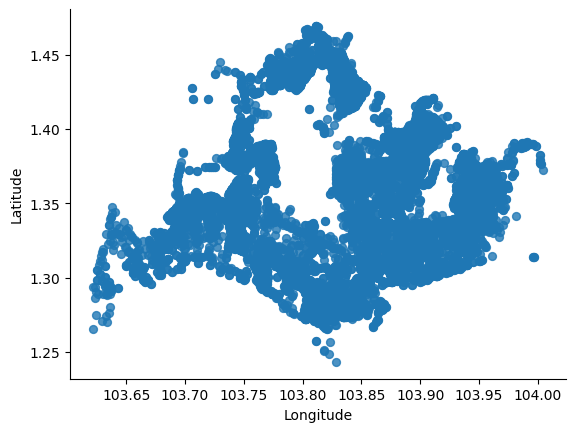

In [288]:
# @title Latitude vs Longitude Plot
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Longitude', y='Latitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [289]:
import csv

def write_to_csv_files(data, filename_prefix, max_rows_per_file=math.inf):
  """
  Writes data to multiple CSV files, each with a maximum of max_rows_per_file rows.

  Args:
    data: The data to write.
    filename_prefix: The prefix for the filenames.
    max_rows_per_file: The maximum number of rows per file. Default is infinite.
  """

  num_files = math.ceil(len(data)/max_rows_per_file)
  for i in range(num_files):
    start_row = i * max_rows_per_file
    end_row = min((i + 1) * max_rows_per_file, len(data))
    filename = f"{filename_prefix}_{i+1}.csv"
    with open(filename, 'w', newline='') as csvfile:
      csvwriter = csv.writer(csvfile)
      csvwriter.writerow(['Description', 'Latitude', 'Longitude', 'RackType', 'RackCount', 'Sheltered'])
      csvwriter.writerows(data[start_row:end_row].values)

In [293]:
# @title Write filtered data to CSV file for Google Maps import
write_data = data.reset_index()

# filter by rack type
only_yellow = False
only_racks = True
if only_yellow:
  write_data = write_data[write_data.RackType == 'Yellow Box']
elif only_racks:
  write_data = write_data[write_data.RackType != 'Yellow Box']

# write csv files with max 2000 rows suitable for Google Maps import
write_to_csv_files(write_data, 'output_racks', 2000)